**Author**: Ashlynn Wimer

**Date**: 2/24/2024

This Python Notebook is here to generate reference maps used in our presentation(s). So far, the only map generated in this notebook is the one used to explain aggregation. The other reference map (seen on our second slide) was created in QGIS.

In [1]:
# Data
import geopandas as gpd
import pandas as pd
import pygris

# Plotting
import cartopy.crs as ccrs
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

In [2]:
#### Get geometries

# pygris our shapes
counties = pygris.counties(['54', '51'], cache=True, cb=True)
rockingham = counties[counties['GEOID'] == '51165']
rockingham_tracts = pygris.tracts(state='51', county='165', cache=True, cb=True)

rockingham.head(), rockingham_tracts.head()

Using the default year of 2021
Using the default year of 2021


(     STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME  \
 1181      51      165  01488970  0500000US51165  51165  Rockingham   
 
                NAMELSAD STUSPS STATE_NAME LSAD       ALAND    AWATER  \
 1181  Rockingham County     VA   Virginia   06  2200944584  10646757   
 
                                                geometry  
 1181  POLYGON ((-79.22096 38.48059, -79.22112 38.482...  ,
     STATEFP COUNTYFP TRACTCE              AFFGEOID        GEOID    NAME  \
 336      51      165  011100  1400000US51165011100  51165011100     111   
 571      51      165  010900  1400000US51165010900  51165010900     109   
 653      51      165  011000  1400000US51165011000  51165011000     110   
 661      51      165  010802  1400000US51165010802  51165010802  108.02   
 682      51      165  011500  1400000US51165011500  51165011500     115   
 
                 NAMELSAD STUSPS         NAMELSADCO STATE_NAME LSAD      ALAND  \
 336     Census Tract 111     VA  Rockingham Coun

In [3]:
# Attach some of the tract level raw rurality data
rockingham_tracts = rockingham_tracts.merge(pd.read_csv('../data/raw/rurality/ruca2010revised.csv', 
                                    dtype={'State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)':str}), 
                                    left_on='GEOID', 
                                    right_on='State-County-Tract FIPS Code (lookup by address at http://www.ffiec.gov/Geocode/)', 
                                    how='left')

def bin_rurality(secondary_code):
    '''
    Quick helper function for converting RUCA codes to Rural, Urban,
    or Suburban classifications. Uses the OEPS classifications.
    '''
    match (secondary_code):
        case 1.0 | 1.1:
            return 'Urban'
        case 2.0 | 2.1 | 4.0 | 4.1:
            return 'Suburban'
        case _:
            return 'Rural'

# Colors for labels
rurality_colors = {
    'Urban':'#EDAE49',
    'Suburban':'#D1495B',
    'Rural':'#00798C'
}

# Merge our rurality data to the geometries
rockingham_tracts['rurality'] = rockingham_tracts['Secondary RUCA Code, 2010 (see errata)'].apply(bin_rurality)
rockingham_tracts['color'] = rockingham_tracts['rurality'].apply(lambda x: rurality_colors[x])
rockingham_tracts = rockingham_tracts[['GEOID', 'rurality', 'color', 'geometry']]
rockingham_tracts.head()


,GEOID,rurality,color,geometry
0,51165011100,Suburban,#D1495B,"POLYGON ((-79.16732 38.57934, -79.16346 38.583..."
1,51165010900,Suburban,#D1495B,"POLYGON ((-78.85815 38.65255, -78.85696 38.652..."
2,51165011000,Suburban,#D1495B,"POLYGON ((-79.09275 38.70231, -79.08656 38.716..."
3,51165010802,Rural,#00798C,"POLYGON ((-78.79141 38.62084, -78.78911 38.620..."
4,51165011500,Urban,#EDAE49,"POLYGON ((-78.99016 38.38652, -78.98924 38.387..."


c:\Python311\Lib\site-packages\shapely\geometry\linestring.py:64: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


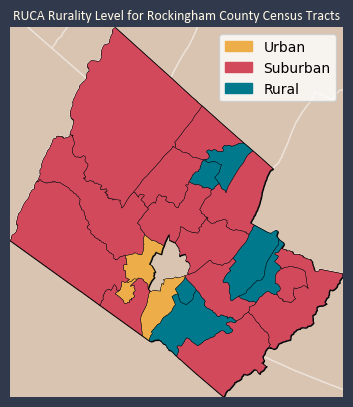

In [16]:
## Set up map projection
proj = ccrs.epsg('2283')

## Get our figure, axes
figure = plt.figure(facecolor='#31394d')
ax = plt.axes(projection=proj)

## Set up bounds
bounds = rockingham.to_crs('2283').bounds
ax.set_extent([bounds['minx'],  bounds['maxx'], bounds['miny'],  bounds['maxy']], crs=proj)

## Add a legend by *manually creating all entries*
ax.legend(handles=\
          [Patch(color=value, label=key) 
           for key, value in rurality_colors.items()]
           )

## Plot our geometries

# Background Layer
ax.add_geometries(counties['geometry'].to_crs(proj),
                  crs=proj,
                  edgecolor='#ede3da',
                  facecolor='#d9c4b1')

# Rockingham itself (For border)
ax.add_geometries(rockingham['geometry'].to_crs(proj), 
                  crs=proj,
                  edgecolor='black',
                  linewidth=3)


ax.add_geometries(rockingham_tracts['geometry'].to_crs(ccrs.epsg('2283')),
                  crs=proj,
                  edgecolor='black',
                  linewidth=.3,
                  facecolor=rockingham_tracts['color'].tolist())

ax.set_axis_off()

ax.set_title('RUCA Rurality Level for Rockingham County Census Tracts',
             size=12, font='Calibri', color='#fdf6e3')

plt.savefig('../results/example_map.png')